In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
import src.loss as loss
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MT, MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [471]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy KL pred_entropy_single')
# predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.MI
# predictor = Predictor.KL

predictor = Predictor.pred_entropy_single


In [4]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [5]:
training = False
save_probabilities = False
loadInference = False


addPastDeforestationInput = True
'''
if training == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if training == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
dates = [2018, 2019]
dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)	
# dates = [2019, 2020]
# dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)	

if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

inference_times = 10


if training == False:


	if type(dataset) == PAMultipleDates:
		# exp_ids = [103, 104, 105, 106, 107, 118, 119, 120, 121, 122] # same date
		exp_ids = [123, 124, 125, 126, 127, 128, 129, 131, 1122, 1121] # earlier date

	if type(dataset) == MTMultipleDates:
		# exp_ids = [108, 109, 110, 111, 112, 113, 114, 115, 116, 117] # same date
		exp_ids = [130, 132, 133, 134, 135, 136, 137, 1125, 1124, 1123] # earlier date

else:
	# exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 140

ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [6]:
exp_ids

[123, 124, 125, 126, 127, 128, 129, 131, 1122, 1121]

In [7]:
figures_path = 'output/figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [8]:
# ic(type(dataset), exp, dataset.dates)


In [9]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [10]:
# np.save('label_not_independent.npy', label_mask)


In [11]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [12]:
label_mask.dtype

dtype('uint8')

In [13]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [14]:
label_mask.dtype

dtype('uint8')

In [15]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [16]:
np.unique(image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

(-0.5, 9199.5, 17729.5, -0.5)

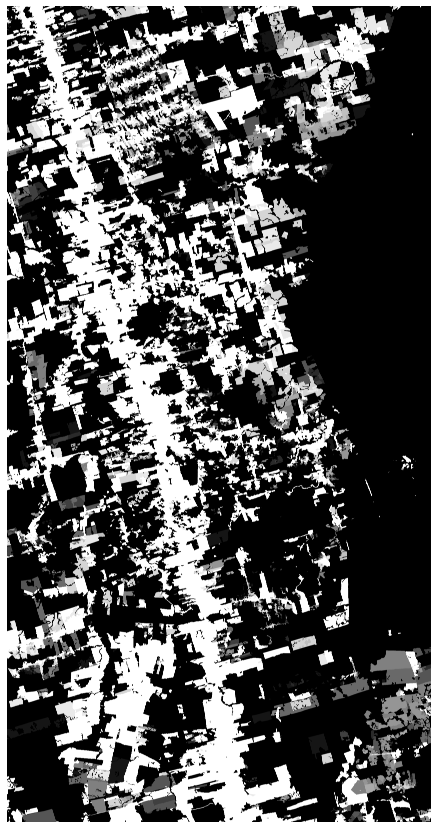

In [17]:


plt.figure(figsize=(15,15))
plt.imshow(image_stack[...,0], cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('output/figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [18]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (17730, 9200, 21)
ic| channels: 21


21

In [19]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [20]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


In [21]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

In [22]:
label_mask.shape

(17730, 9200, 1)

(-0.5, 9199.5, 17729.5, -0.5)

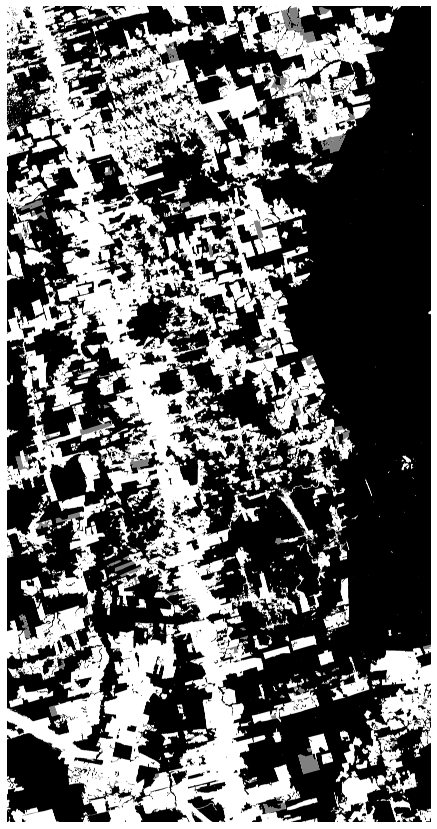

In [23]:

plt.figure(figsize=(15,15))
if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('output/figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [24]:
np.unique(label_mask)

array([0, 1, 2], dtype=uint8)

In [25]:
if training == True:
    print(coords_train)

In [26]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


In [27]:
'''
import src.patchesHandler as sp
importlib.reload(sp)

patchesHandler = sp.PatchesHandlerMultipleDates(
		dataset)
'''

'\nimport src.patchesHandler as sp\nimportlib.reload(sp)\n\npatchesHandler = sp.PatchesHandlerMultipleDates(\n\t\tdataset)\n'

In [28]:
import src.plot as _plt
importlib.reload(_plt)

<module 'src.plot' from 'd:\\Jorge\\deforestation_uncertainty\\src\\plot.py'>

In [29]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))
    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], 
            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],
            image_stack[...,[44,45,46]],            
            lims = None, 
            titles = ['2015', '2016', '2017', '2018', '2019'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False, False],
            invertMask = [False, False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))\n    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], \n            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],\n            image_stack[...,[44,45,46]],            \n            lims = None, \n            titles = ['2015', '2016', '2017', '2018', '2019'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False, False],\n            invertMask = [False, False, False, False, False])\n"

In [30]:
inputSnipShow = False

In [31]:
if training == True and inputSnipShow == True:
    idx = 2800
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [32]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [33]:
if training == True and inputSnipShow == True:

    idx = 97
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [34]:
if training == True and inputSnipShow == True:

    idx = 1200
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [35]:
inputSnipShow = False
if training == True and inputSnipShow == True:

    idx = 400
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [36]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [37]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [38]:
# Creating folder for the experiment

# path_exp = dataset.paths.experiment + 'exp' + str(exp)
# path_models = path_exp+'/models'
# path_maps = path_exp+'/pred_maps'

# if not os.path.exists(path_exp):
#     os.makedirs(path_exp)   
# if not os.path.exists(path_models):
#     os.makedirs(path_models)   
# if not os.path.exists(path_maps):
#     os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [39]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [40]:
# path_exp

In [41]:
channels

21

In [42]:
image_stack.shape

(17730, 9200, 21)

In [43]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = loss.weighted_categorical_crossentropy(weights)
        
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

In [44]:
if training == True:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('loss_history.png')

In [45]:
image_stack.shape

(17730, 9200, 21)

In [46]:
if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
    patchesHandler.dataset.image_channels[-1]

In [47]:
if type(dataset) == PAMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [48]:
image_stack.shape

(17730, 9200, 21)

In [49]:
#%% Test loop

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
# del image_stack


-30.0 -16.0


In [50]:

h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)


class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, inference_times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], inference_times), dtype = np.float32)

    new_model = utils_v1.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
        nb_filters = nb_filters, n_classes = class_n, dropout_seed = None, training = False)

    patchesHandler.class_n = class_n

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,inference_times):
            print('time: ', tm)
            
            # Recinstructing predicted map
            start_test = time.time()

            path_exp = dataset.paths.experiment + 'exp' + str(exp_ids[tm])
            path_models = path_exp + '/models'
            # ic(path_models+ '/' + method +'_'+str(0)+'.h5')
            model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
            for l in range(1, len(model.layers)):
                new_model.layers[l].set_weights(model.layers[l].get_weights())
            
            '''
            args_network = {'patch_size_rows': patch_size_rows,
                'patch_size_cols': patch_size_cols,
                'c': c,
                'nb_filters': nb_filters,
                'class_n': class_n,
                'dropout_seed': inference_times}
            '''
            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    # model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
                    # patch_size_cols, a = args_network)
                    
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


In [51]:
'''
with tf.device('/cpu:0'):
    for tm in range(0,times):
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) 
'''

"\nwith tf.device('/cpu:0'):\n    for tm in range(0,times):\n        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) \n"

In [52]:
del image1_pad


In [53]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, inference_times), dtype = np.float32)

    for tm in range(0, inference_times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)




In [54]:
# prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
prob_rec.shape



(17760, 9216, 10)

In [55]:
# prob_rec = np.transpose(prob_rec, (2, 0, 1))
# prob_rec = np.expand_dims(prob_rec, axis=-1)

In [56]:

if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))


In [57]:
prob_rec.shape

(17760, 9216, 10)

In [58]:
prob_rec.shape

(17760, 9216, 10)

In [59]:
mean_prob = np.mean(prob_rec, axis = -1)
# np.save(path_maps+'/prob_mean.npy', mean_prob)


In [60]:
ic(np.min(mean_prob), np.mean(mean_prob), np.max(mean_prob))

ic| np.min(mean_prob): 1.4644367e-15
    np.mean(mean_prob): 0.012334157
    np.max(mean_prob): 0.9999992


(1.4644367e-15, 0.012334157, 0.9999992)

In [61]:
ic(mean_prob.shape)

ic| mean_prob.shape: (17760, 9216)


(17760, 9216)

In [62]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

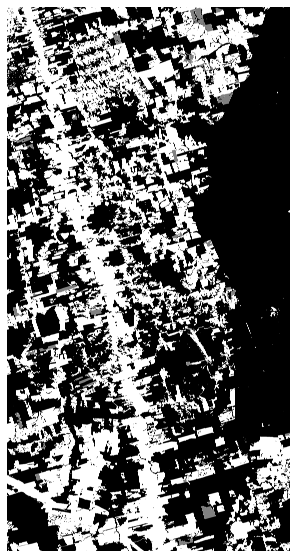

In [63]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('output/figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [64]:
if issubclass(type(dataset), MultipleDates):
    label_mask = np.squeeze(label_mask)

In [65]:
mean_prob.shape

(17730, 9200)

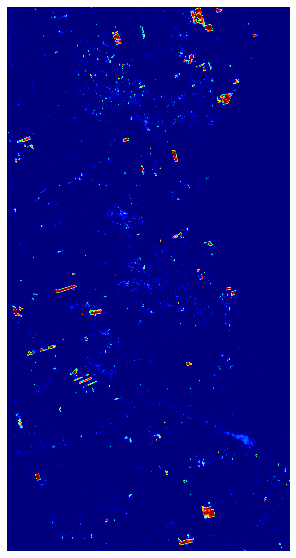

In [66]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('output/figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [67]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(17730, 9200)


In [68]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [69]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

88.42


In [70]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (17760, 9216, 10)


In [71]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [72]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [73]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    
    # sum_entropy = 0
    sum_entropy = np.zeros(pred_probs.shape[1:-1])

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI


def expected_KL_divergence(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    KL_divergence = np.zeros(pred_mean.shape[0:2])

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]

    for i in range(n):
        for k in range(K):
            # print(np.mean(pred_mean[..., k]), np.mean(pred_probs[i, ..., k]), np.mean(KL_divergence))
            # pdb.set_trace()
            KL_divergence += pred_mean[..., k] * np.log(pred_mean[..., k] / (pred_probs[i, ..., k] + epsilon) + epsilon)
    KL_divergence /= n
    return KL_divergence


In [74]:
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))
ic(prob_rec.shape)

ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.012330051
    np.max(prob_rec): 1.0
ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [75]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)

pred_entropy_single = single_experiment_entropy(prob_rec[0]).astype(np.float32)

pred_var = predictive_variance(prob_rec).astype(np.float32)

MI = mutual_information(prob_rec).astype(np.float32)



ic| pred_entropy.shape: (17760, 9216)
ic| n: 10, K: 1


In [76]:
KL = expected_KL_divergence(prob_rec).astype(np.float32)

In [77]:
np.mean(KL)

0.0035281242

In [78]:

pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0


In [79]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.009806012
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): 4.9258988e-14
    np.mean(pred_entropy): 0.010970183
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (17760, 9216)
    pred_entropy_to_show.shape: (17730, 9200)


((17760, 9216), (17730, 9200))

In [80]:
prob_rec.shape

(10, 17760, 9216, 1)

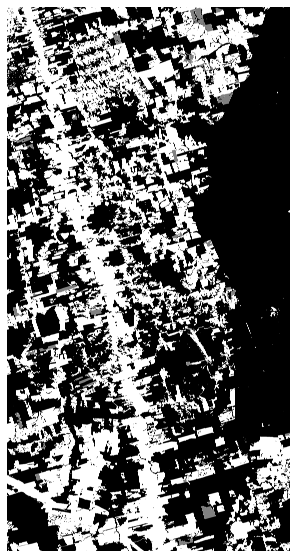

In [81]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('output/figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [82]:
# Computing error mask
# label_mask
'''
for idx in range(10):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(prob_rec[idx], cmap = 'jet')
# fig.savefig('output/figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')
'''

"\nfor idx in range(10):\n    fig, ax = plt.subplots(figsize=(10,10))\n    ax.set_xticks([])\n    ax.set_yticks([])\n    ax.imshow(prob_rec[idx], cmap = 'jet')\n# fig.savefig('output/figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')\n"

(-0.5, 9199.5, 17729.5, -0.5)

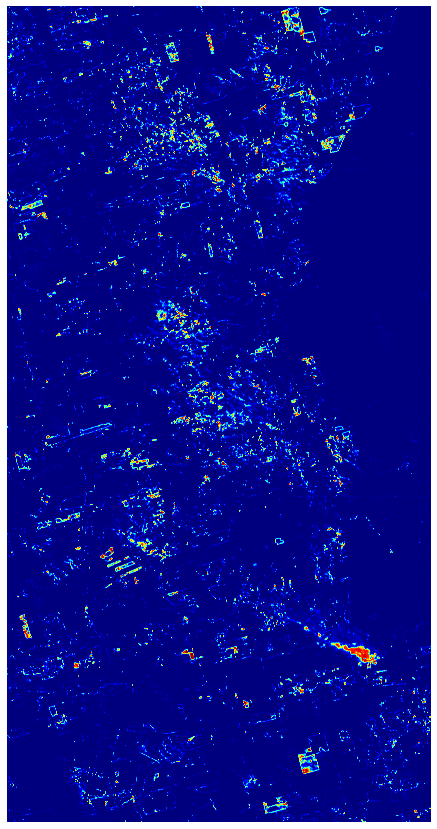

In [83]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
# show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
#plt.savefig('output/figures/Para' + title_name + ' uncertainty predictive entropy.png', 
 #   dpi=150, bbox_inches='tight')

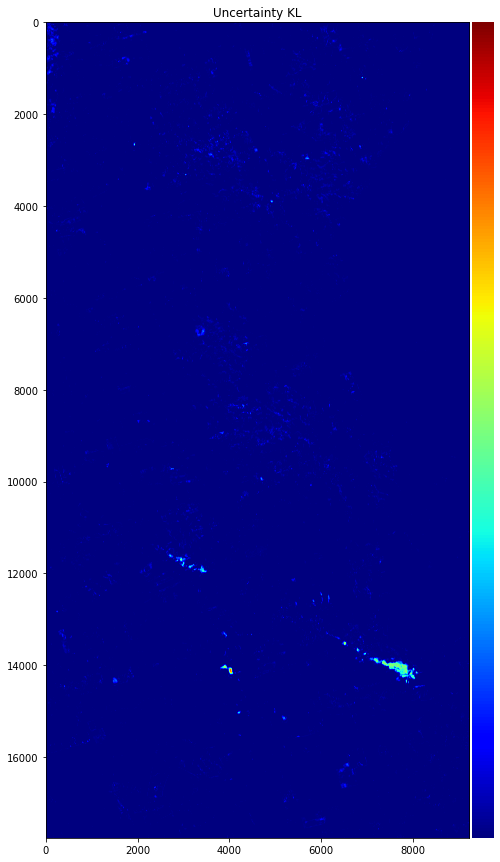

In [84]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
show_im(KL, ax, title = 'Uncertainty KL')
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' uncertainty KL.png', 
    dpi=150, bbox_inches='tight')

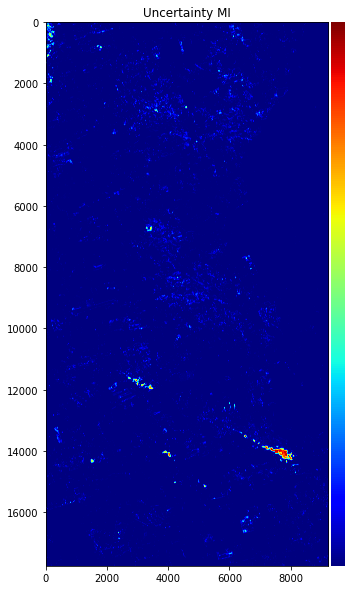

In [85]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' uncertainty MI.png', 
    dpi=150, bbox_inches='tight')

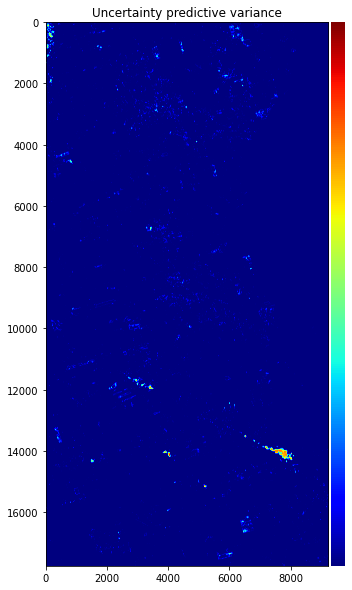

In [86]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_var, ax, title = 'Uncertainty predictive variance')
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' uncertainty Predictive variance.png', 
    dpi=150, bbox_inches='tight')

In [87]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (17760, 9216)


(17760, 9216)

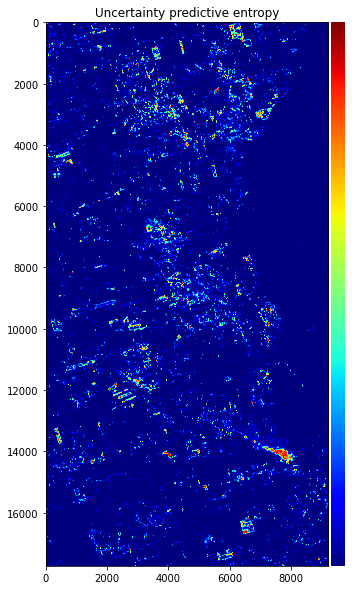

In [88]:

# pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()

# ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

# pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [89]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (10, 17760, 9216, 1)
ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.012330051
    np.max(prob_rec): 1.0


(0.0, 0.012330051, 1.0)

In [90]:


'''
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


"\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [91]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([81558000, 65246400, 16311600], dtype=int64))


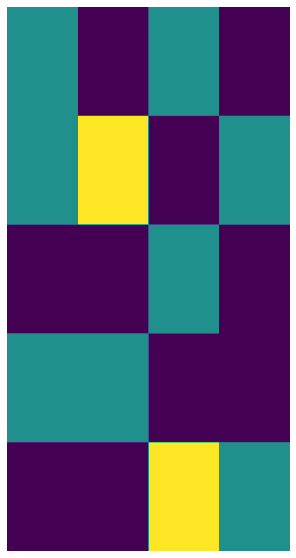

In [92]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('output/figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [93]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [94]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  1838508, 161277492], dtype=int64))


(array([  0, 255], dtype=uint8), array([  1838508, 161277492], dtype=int64))

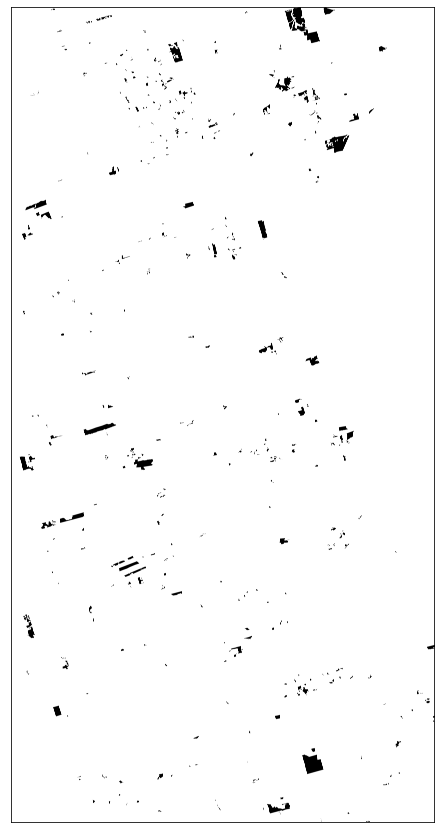

In [95]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('output/figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [96]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (16311600,)
ic| label_mask_val_valid.shape: (9450701,)


(9450701,)

In [97]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [98]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.405385, F-Score=0.824


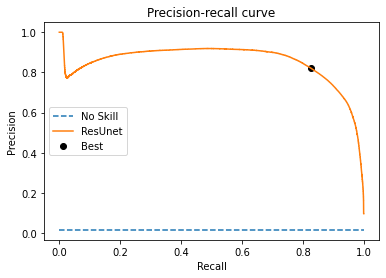

In [99]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('output/figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [472]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
threshold = 0.5

if predictor != Predictor.pred_entropy_single:
    predicted[mean_prob>=threshold] = 1
    predicted[mean_prob<threshold] = 0
else:
    print("Single entropy")
    predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]>=threshold] = 1
    predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
predicted_unpad[label_mask == 2] = 0
ic(predicted_unpad.shape, predicted.shape)
del predicted

(17730, 9200)
Single entropy
(array([0., 1.], dtype=float32), array([161444636,   1671364], dtype=int64))


ic| predicted_unpad.shape: (17730, 9200)
    predicted.shape: (17730, 9200)


In [473]:
threshold

0.5

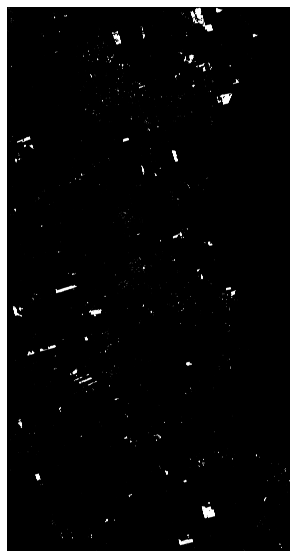

In [474]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [475]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [476]:
# mean_prob_unpad.shape

In [477]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [478]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [479]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [480]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [481]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask_current_deforestation.shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)
    mean_prob.shape: (17730, 9200)


((17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200))

In [482]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)


ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54181542,)


(54181542,)

In [483]:
importlib.reload(_metrics)
removePolygons = True
if removePolygons == True:
    # remove polygons smaller than 625 px
    min_polygon_area = 625 # pixels

    predicted_unpad, label_mask = _metrics.removeSmallPolygonsForMetrics(predicted_unpad, label_mask,
        min_polygon_area)
    predicted_masked, label_masked = _metrics.getTest(predicted_unpad, label_mask, mask_amazon_ts)

    predicted_test = predicted_masked
    label_mask_current_deforestation_test = label_masked


ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161669674,   1446326], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161767507,   1348493], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([163018167,     97833], dtype=int64))
ic| predicted.shape: (17730, 9200), label_mask.shape: (17730, 9200)
ic| predicted_masked.shape: (81558000,)
    label_masked.shape: (81558000,)
ic| np.unique(label_masked, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                  array([53410474,   726546, 27420980], dtype=int64))
ic| predicted_masked.shape: (54137020,)
    label_masked.shape: (54137020,)


In [484]:

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        oa = round(accuracy_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        if removePolygons == False:
                mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                        mean_prob_test)*100, 2)
        else:
                '''
                # Computing metrics over the test tiles
                # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
                ref1 = np.ones_like(label_mask).astype(np.float32)

                ref1 [label_mask == 2] = 0
                TileMask = mask_amazon_ts * ref1
                GTTruePositives = label_mask==1

                # Metrics for th=0.5    

                Npoints = 50
                Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
                ProbList = np.linspace(Pmax,0,Npoints)

                metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 625)
                print('Metrics th = 0.5: ', metrics_*100)
                '''
                pass


In [485]:
ic(f1, precision, recall)
# ic(f1, precision, recall)


ic| f1: 80.66, precision: 94.41, recall: 70.4


(80.66, 94.41, 70.4)

In [486]:
ic(oa)

ic| oa: 99.55


99.55

### Metrics for validation set in forest/deforestation detection

In [487]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (17730, 9200)


(17730, 9200)

In [488]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [489]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 82.9
    precision_val: 88.15
    recall_val: 78.25
    mAP_val: 85.22


(82.9, 88.15, 78.25, 85.22)

In [490]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    # Computing metrics over the test tiles
    # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
    ref1 = np.ones_like(label_mask).astype(np.uint8)

    ref1 [label_mask == 2] = 0
    TileMask = mask_amazon_ts * ref1
    GTTruePositives = label_mask==1

    # Metrics for th=0.5    

    ProbList_05 = [0.5]

    metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
    print('Metrics th = 0.5: ', metrics_05*100)


In [491]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([162380425,    735575], dtype=int64))


In [492]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (17730, 9200)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   612795, 162380425,    122780], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   612795, 162380425,    122780], dtype=int64))

In [493]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)


((17730, 9200), (17730, 9200))

In [494]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('output/figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

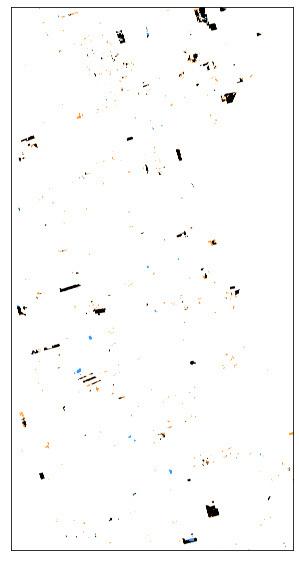

In [495]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('output/figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


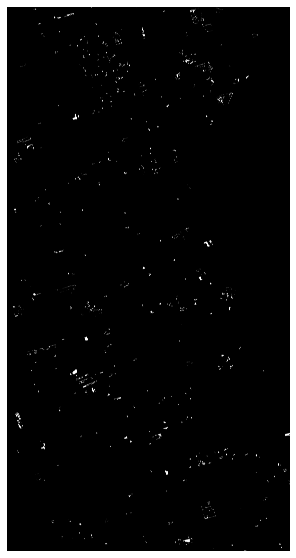

In [496]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [497]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (17730, 9200)
ic| mask_amazon_ts.shape: (17730, 9200)
ic| label_mask_test.shape: (81558000,)
ic| error_mask_test.shape: (54137020,)


(54137020,)

In [498]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [499]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  
pred_var_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_var, npad), mask_amazon_ts),
        label_mask_test)

MI_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(MI, npad), mask_amazon_ts),
        label_mask_test)

KL_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(KL, npad), mask_amazon_ts),
        label_mask_test)


ic| pred_entropy.shape: (17760, 9216)
    utils_v1.unpadIm(pred_entropy, npad).shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask_test.shape: (81558000,)


In [500]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

pred_var_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_var, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

MI_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(MI, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

KL_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(KL, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)


In [501]:
pred_entropy_single_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_amazon_ts),
        label_mask_test)

pred_entropy_single_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

        

In [502]:
# dataset.previewLims1 = np.array([2200, 3200, 6900, 7900])
# dataset.previewLims2 = np.array([500, 1500, 3500, 4500])
# dataset.previewBands = [2, 1, 0] 

In [503]:


# dataset.previewLims1 = np.array([7600, 8600, 4500, 5500])
# dataset.previewLims1 = np.array([12200, 13200, 200, 1200])
# dataset.previewLims1 = np.array([11800, 12800, 9000, 10000])

# dataset.previewLims1 = np.array([11500, 12500, 9000, 10000])

# dataset.previewLims2 = np.array([5000, 6000, 9500, 10500])

ic(dataset.previewLims1, dataset.previewLims2)
lims = dataset.previewLims1
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))
lims = dataset.previewLims2
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
ic(mask_amazon_ts.shape)


ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| mask_amazon_ts.shape: (17730, 9200)


(17730, 9200)

In [504]:
uncertainty_vlims = [np.min(pred_entropy_to_show), np.max(pred_entropy_to_show)]


ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


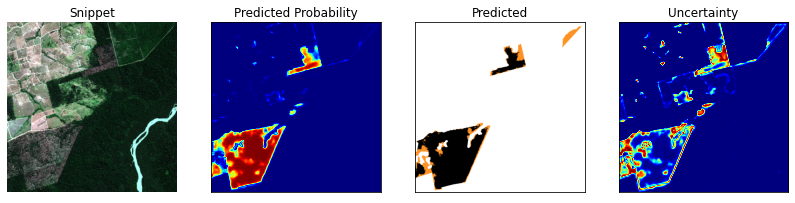

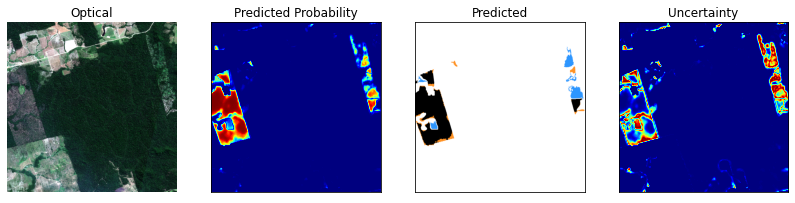

In [505]:


plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Snippet', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False], uncertainty_vlims = uncertainty_vlims)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Optical', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False], uncertainty_vlims = uncertainty_vlims)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2.png', dpi=150, bbox_inches='tight')

In [506]:

if predictor == Predictor.pred_var:
    uncertainty = pred_var_test
    uncertainty_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    uncertainty = MI_test
    uncertainty_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    uncertainty = pred_entropy_test
    uncertainty_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.KL:
    uncertainty = KL_test
    uncertainty_val = KL_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287

elif predictor == Predictor.pred_entropy_single:
    uncertainty = pred_entropy_single_test
    uncertainty_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [507]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(uncertainty): -0.0
    np.mean(uncertainty): 0.013641989
    np.max(uncertainty): 0.36787948
ic| np.min(pred_entropy): 4.9258988e-14
    np.mean(pred_entropy): 0.010970183
    np.max(pred_entropy): 0.36787948


(4.9258988e-14, 0.010970183, 0.36787948)

In [508]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, uncertainty.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, uncertainty, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, uncertainty_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (54137020,), uncertainty.shape: (54137020,)
ic| roc_auc: 0.9170260105223563


0.9170260105223563

Best Threshold=0.040898, G-Mean=0.885


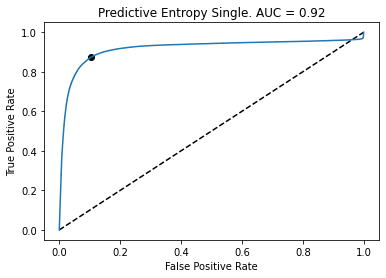

In [509]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [510]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.04089822


In [511]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [512]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(uncertainty)
y_pred_thresholded[uncertainty >= best_threshold_uncertainty] = 1


In [513]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [514]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [515]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [516]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('output/figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [517]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('output/figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [518]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [519]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


Get precision-recall threshold

In [520]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, uncertainty_val, pos_label=pos_label)



In [521]:
ic(thresholds)

ic| thresholds: array([0.0000006 , 0.00000061, 0.00000069, ..., 0.36787942, 0.36787945,
                       0.36787948], dtype=float32)


array([0.0000006 , 0.00000061, 0.00000069, ..., 0.36787942, 0.36787945,
       0.36787948], dtype=float32)

In [522]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.326569, F-Score=0.334


C:\Users\jchamorro\AppData\Local\Temp\ipykernel_11688\3129774117.py:1: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


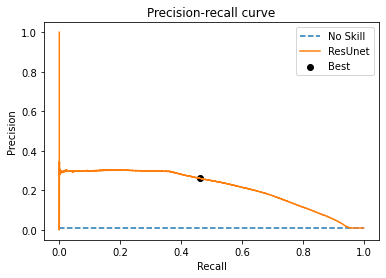

In [523]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('output/figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [524]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [525]:
ic(np.min(uncertainty), np.average(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): -0.0
    np.average(uncertainty): 0.013641989
    np.max(uncertainty): 0.36787948


(-0.0, 0.013641989, 0.36787948)

In [526]:
# plt.hist(uncertainty)

In [527]:
ic(uncertainty.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| uncertainty.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [528]:
ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
ic(np.unique(label_mask_current_deforestation_test))

ic| uncertainty.shape: (54137020,)
    label_mask_current_deforestation_test.shape: (54137020,)
ic| np.unique(label_mask_current_deforestation_test): array([0, 1], dtype=uint8)


array([0, 1], dtype=uint8)

In [529]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): -0.0
    np.mean(uncertainty): 0.013641989
    np.max(uncertainty): 0.36787948


(-0.0, 0.013641989, 0.36787948)

In [530]:
importlib.reload(_metrics)

threshold_uncertainty = 0.15

predicted_thresholded = np.zeros_like(uncertainty).astype(np.int8)
predicted_thresholded[uncertainty >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (54137020,)


(54137020,)

In [531]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([52551060,  1585960], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([100773300,   1756712,  60585988], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64))


((array([0, 1], dtype=uint8), array([52551060,  1585960], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([100773300,   1756712,  60585988], dtype=int64)),
 (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64)))

In [532]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    total_test_area = mask_test.copy()
    total_test_area[label_mask == 2] = 0

    percentage = np.count_nonzero(uncertainty_mask.flatten()) / np.count_nonzero(total_test_area.flatten())
    return total_test_area, percentage

total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| percentage: 0.029295295529750253


0.029295295529750253

In [533]:
AA = np.count_nonzero(predicted_thresholded.flatten()) / len(label_mask_current_deforestation_test)
ic(AA)

# metrics_values = _metrics.getAA_Recall(uncertainty, 
#                 label_mask_current_deforestation_test, 
#                 predicted_test, [threshold_uncertainty])


ic| AA: 0.029295295529750253


0.029295295529750253

In [534]:
predictor

<Predictor.pred_entropy_single: 5>

In [535]:

importlib.reload(_metrics)

# threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
if predictor == Predictor.pred_entropy:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
elif predictor == Predictor.pred_var:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*0.13/0.36 for x in threshold_list] + [np.max(uncertainty)-0.0015, np.max(uncertainty)-0.0008]
elif predictor == Predictor.MI:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*0.235/0.36 for x in threshold_list] + [np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
elif predictor == Predictor.KL:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*1.0/0.36 for x in threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                
        # threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
print(threshold_list)
loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        # ic(metrics_values)


ic| uncertainty.shape: (54137020,)
    label_mask_current_deforestation_test.shape: (54137020,)


[0.006944444444444445, 0.01388888888888889, 0.020833333333333332, 0.02777777777777778, 0.041666666666666664, 0.06944444444444445, 0.1388888888888889, 0.22222222222222224, 0.2777777777777778, 0.4166666666666667, 0.5555555555555556, 0.625, 0.6944444444444444, 0.7500000000000001, 0.8333333333333334, 0.9444444444444445, 1.0, 1.1549454154968262, 1.1579454154968263]
threshold 0.006944444444444445
(45866562,) (45866562,)


ic| label_current_deforestation_test_classified_incorrect.shape: (8270458,)
    predicted_test_classified_incorrect.shape: (8270458,)


cm_correct [[45734013      329]
 [    5493   126727]]


ic| TP_H + FN_H + FP_H + TN_H: 8270458
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 8270458
    len(label_mask_current_deforestation_test): 54137020


cm_incorrect [[7646180   29952]
 [ 209552  384774]]
[0.99741059 0.9584556  0.17442392 0.15276899 0.92777882 0.64741236]
threshold 0.01388888888888889
(48056836,) (48056836,)


ic| label_current_deforestation_test_classified_incorrect.shape: (6080184,)
    predicted_test_classified_incorrect.shape: (6080184,)


cm_correct [[47886934      707]
 [    8951   160244]]


ic| TP_H + FN_H + FP_H + TN_H: 6080184
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 6080184
    len(label_mask_current_deforestation_test): 54137020


cm_incorrect [[5493259   29574]
 [ 206094  351257]]
[0.99560736 0.94709655 0.22055589 0.11231102 0.92234351 0.63022584]
threshold 0.020833333333333332
(49014347,) (49014347,)


ic| label_current_deforestation_test_classified_incorrect.shape: (5122673,)
    predicted_test_classified_incorrect.shape: (5122673,)


cm_correct [[48818974     1056]
 [   11494   182823]]


ic| TP_H + FN_H + FP_H + TN_H: 5122673
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 5122673
    len(label_mask_current_deforestation_test): 54137020


cm_incorrect [[4561219   29225]
 [ 203551  328678]]
[0.99425709 0.94084923 0.25163307 0.09462421 0.9183438  0.61754996]
threshold 0.02777777777777778
(49617337,) (49617337,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4519683,)
    predicted_test_classified_incorrect.shape: (4519683,)


cm_correct [[49401968     1350]
 [   13588   200431]]


ic| TP_H + FN_H + FP_H + TN_H: 4519683
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 4519683
    len(label_mask_current_deforestation_test): 54137020


cm_incorrect [[3978225   28931]
 [ 201457  311070]]
[0.99330958 0.93651031 0.27586829 0.083486   0.91490907 0.60693388]
threshold 0.041666666666666664
(50403077,) (50403077,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3733943,)
    predicted_test_classified_incorrect.shape: (3733943,)


cm_correct [[50154166     1837]
 [   17325   229749]]


ic| TP_H + FN_H + FP_H + TN_H: 3733943
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 3733943
    len(label_mask_current_deforestation_test): 54137020


cm_incorrect [[3226027   28444]
 [ 197720  281752]]
[0.99206774 0.92987931 0.31622086 0.06897208 0.90830314 0.58762973]
threshold 0.06944444444444445
(51317125,) (51317125,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2819895,)
    predicted_test_classified_incorrect.shape: (2819895,)


cm_correct [[51016371     2619]
 [   24420   273715]]


ic| TP_H + FN_H + FP_H + TN_H: 2819895
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 2819895
    len(label_mask_current_deforestation_test): 54137020


cm_incorrect [[2363822   27662]
 [ 190625  237786]]
[0.99052234 0.9180908  0.37673458 0.05208811 0.89579127 0.55504177]
threshold 0.1388888888888889
(52436336,) (52436336,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1700684,)
    predicted_test_classified_incorrect.shape: (1700684,)
ic

cm_correct [[52043874     5316]
 [   41874   345272]]
cm_incorrect [[1336319   24965]
 [ 173171  166229]]


| TP_H + FN_H + FP_H + TN_H: 1700684
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 1700684
    len(label_mask_current_deforestation_test): 54137020


[0.9848369  0.89183925 0.47522387 0.03141444 0.86942582 0.48977313]
threshold 0.22222222222222224
(53112509,) (53112509,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1024511,)
    predicted_test_classified_incorrect.shape: (1024511,)
ic| TP_H + FN_H + FP_H + TN_H: 1024511
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 1024511
    len(label_mask_current_deforestation_test): 54137020


cm_correct [[52633570     9880]
 [   63621   405438]]
cm_incorrect [[746623  20401]
 [151424 106063]]
[0.976211   0.86436461 0.55803487 0.01892441 0.83868136 0.41191594]
threshold 0.2777777777777778
(53424816,) (53424816,)


ic| label_current_deforestation_test_classified_incorrect.shape: (712204,)
    predicted_test_classified_incorrect.shape: (712204,)
ic| TP_H + FN_H + FP_H + TN_H: 712204
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 712204
    len(label_mask_current_deforestation_test): 54137020


cm_correct [[52882835    14989]
 [   80482   446510]]
cm_incorrect [[497358  15292]
 [134563  64991]]
[0.96752106 0.84728041 0.61456535 0.01315558 0.80952381 0.32568127]
threshold 0.4166666666666667
(54137020,) (54137020,)


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


cm_correct [[53380193    30281]
 [  215045   511501]]
cm_incorrect []
[nan nan nan  0. nan nan]
threshold 0.5555555555555556
(54137020,) (54137020,)


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


cm_correct [[53380193    30281]
 [  215045   511501]]
cm_incorrect []
[nan nan nan  0. nan nan]
threshold 0.625
(54137020,) (54137020,)


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


cm_correct [[53380193    30281]
 [  215045   511501]]
cm_incorrect []
[nan nan nan  0. nan nan]
threshold 0.6944444444444444
(54137020,) (54137020,)


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


cm_correct [[53380193    30281]
 [  215045   511501]]
cm_incorrect []
[nan nan nan  0. nan nan]
threshold 0.7500000000000001
(54137020,) (54137020,)


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


cm_correct [[53380193    30281]
 [  215045   511501]]
cm_incorrect []
[nan nan nan  0. nan nan]
threshold 0.8333333333333334
(54137020,) (54137020,)


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


cm_correct [[53380193    30281]
 [  215045   511501]]
cm_incorrect []
[nan nan nan  0. nan nan]
threshold 0.9444444444444445
(54137020,) (54137020,)


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


cm_correct [[53380193    30281]
 [  215045   511501]]
cm_incorrect []
[nan nan nan  0. nan nan]
threshold 1.0
(54137020,) (54137020,)


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


cm_correct [[53380193    30281]
 [  215045   511501]]
cm_incorrect []
[nan nan nan  0. nan nan]
threshold 1.1549454154968262
(54137020,) (54137020,)


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


cm_correct [[53380193    30281]
 [  215045   511501]]
cm_incorrect []
[nan nan nan  0. nan nan]
threshold 1.1579454154968263
(54137020,) (54137020,)


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


cm_correct [[53380193    30281]
 [  215045   511501]]
cm_incorrect []
[nan nan nan  0. nan nan]


In [536]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| uncertainty.shape: (54137020,)
    label_mask_current_deforestation_test.shape: (54137020,)


threshold 0.006944444444444445
(54137020,) (54137020,)
cm_audited [[53410145      329]
 [    5493   721053]]
[0.99954393 0.99243957]
threshold 0.01388888888888889
(54137020,) (54137020,)
cm_audited [[53409767      707]
 [    8951   717595]]
[0.99901573 0.98768006]
threshold 0.020833333333333332
(54137020,) (54137020,)
cm_audited [[53409418     1056]
 [   11494   715052]]
[0.99852536 0.98417994]
threshold 0.02777777777777778
(54137020,) (54137020,)
cm_audited [[53409124     1350]
 [   13588   712958]]
[0.99811006 0.98129781]
threshold 0.041666666666666664
(54137020,) (54137020,)
cm_audited [[53408637     1837]
 [   17325   709221]]
[0.99741653 0.9761543 ]
threshold 0.06944444444444445
(54137020,) (54137020,)
cm_audited [[53407855     2619]
 [   24420   702126]]
[0.99628376 0.96638891]
threshold 0.1388888888888889
(54137020,) (54137020,)
cm_audited [[53405158     5316]
 [   41874   684672]]
[0.99229552 0.94236566]
threshold 0.22222222222222224
(54137020,) (54137020,)
cm_audited [[5340059

ic| metric_values_audited: array([[0.99954393, 0.99243957],
                                  [0.99901573, 0.98768006],
                                  [0.99852536, 0.98417994],
                                  [0.99811006, 0.98129781],
                                  [0.99741653, 0.9761543 ],
                                  [0.99628376, 0.96638891],
                                  [0.99229552, 0.94236566],
                                  [0.98531521, 0.91243362],
                                  [0.97732557, 0.88922656],
                                  [0.94410852, 0.70401736],
                                  [0.94410852, 0.70401736],
                                  [0.94410852, 0.70401736],
                                  [0.94410852, 0.70401736],
                                  [0.94410852, 0.70401736],
                                  [0.94410852, 0.70401736],
                                  [0.94410852, 0.70401736],
                                  [0.944

cm_audited [[53380193    30281]
 [  215045   511501]]
[0.94410852 0.70401736]


In [537]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [538]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(uncertainty,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(uncertainty,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [539]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [540]:
save_figures = True

In [541]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}

m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

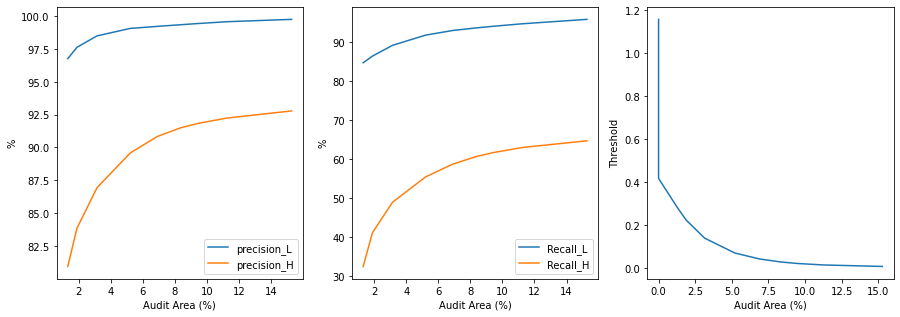

In [542]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('output/figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [543]:
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]


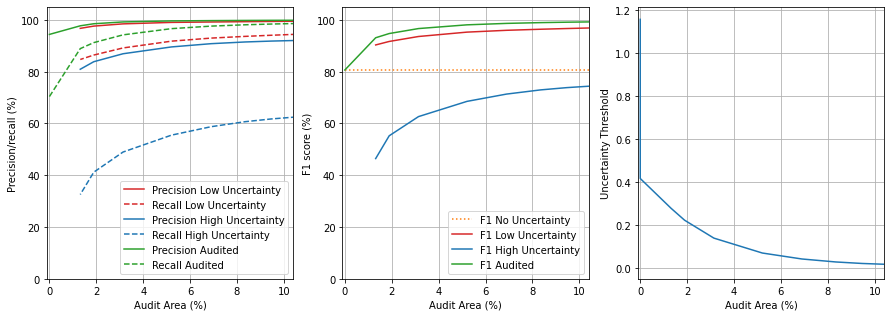

In [544]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()

# ax2.plot(np.append(0, m['AA']*100), 
#     np.append(f1, np.ones_like(m['AA']) * f1), 
#     'C1:', label="F1 No Uncertainty")
ax2.plot(range(int(xlim[0]), int(xlim[1] + 2)), 
    np.ones(int(xlim[1] + 2)) * f1, 
    'C1:', label="F1 No Uncertainty")



ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Uncertainty Threshold')
ax3.grid()
ax3.set_xlim(xlim)



# if save_figures == True:
if True:
    plt.savefig('output/figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [545]:
np.append(np.append(0, m['AA']*100), 10.5)

array([ 0.        , 15.27689925, 11.23110212,  9.46242146,  8.34859954,
        6.89720823,  5.2088109 ,  3.14144369,  1.8924407 ,  1.31555819,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       10.5       ])

In [546]:
AA

0.029295295529750253

In [547]:


m

{'precision_L': array([0.99741059, 0.99560736, 0.99425709, 0.99330958, 0.99206774,
        0.99052234, 0.9848369 , 0.976211  , 0.96752106,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan]),
 'recall_L': array([0.9584556 , 0.94709655, 0.94084923, 0.93651031, 0.92987931,
        0.9180908 , 0.89183925, 0.86436461, 0.84728041,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan]),
 'recall_Ltotal': array([0.17442392, 0.22055589, 0.25163307, 0.27586829, 0.31622086,
        0.37673458, 0.47522387, 0.55803487, 0.61456535,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan]),
 'AA': array([0.15276899, 0.11231102, 0.09462421, 0.083486  , 0.06897208,
        0.05208811, 0.03141444, 0.01892441, 0.01315558, 0.        ,
        0.        , 0.      

In [548]:
m_audited

{'precision': array([0.99954393, 0.99901573, 0.99852536, 0.99811006, 0.99741653,
        0.99628376, 0.99229552, 0.98531521, 0.97732557, 0.94410852,
        0.94410852, 0.94410852, 0.94410852, 0.94410852, 0.94410852,
        0.94410852, 0.94410852, 0.94410852, 0.94410852]),
 'recall': array([0.99243957, 0.98768006, 0.98417994, 0.98129781, 0.9761543 ,
        0.96638891, 0.94236566, 0.91243362, 0.88922656, 0.70401736,
        0.70401736, 0.70401736, 0.70401736, 0.70401736, 0.70401736,
        0.70401736, 0.70401736, 0.70401736, 0.70401736]),
 'f1': array([0.99597908, 0.99331556, 0.99130076, 0.98963254, 0.98667088,
        0.98110866, 0.96668629, 0.94747494, 0.93119698, 0.80657527,
        0.80657527, 0.80657527, 0.80657527, 0.80657527, 0.80657527,
        0.80657527, 0.80657527, 0.80657527, 0.80657527])}

In [549]:
# exp

In [550]:
threshold_list

[0.006944444444444445,
 0.01388888888888889,
 0.020833333333333332,
 0.02777777777777778,
 0.041666666666666664,
 0.06944444444444445,
 0.1388888888888889,
 0.22222222222222224,
 0.2777777777777778,
 0.4166666666666667,
 0.5555555555555556,
 0.625,
 0.6944444444444444,
 0.7500000000000001,
 0.8333333333333334,
 0.9444444444444445,
 1.0,
 1.1549454154968262,
 1.1579454154968263]

In [551]:
# threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]


In [552]:
predictor

<Predictor.pred_entropy_single: 5>

In [553]:

importlib.reload(_metrics)


# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
#threshold_list2 = [0.09] # exp 77 PA 50 runs
# threshold_list2 = [0.085] # exp 77 PA 30 runs
# threshold_list2 = [0.085] # exp 77 PA 10 runs
# threshold_list2 = [0.083] # exp 77 PA 5 runs
threshold_list2 = [0.065] # exp 77 PA 5 runs
threshold_list2 = [0.06] # exp 77 PA 5 runs
threshold_list2 = [0.0825] # exp 77 PA 3 runs

if predictor == Predictor.pred_entropy:
        if issubclass(type(dataset), PA):
                threshold_list2 = [0.163]
                threshold_list2 = [0.151]

        elif issubclass(type(dataset), MT):
                threshold_list2 = [0.116]
                threshold_list2 = [0.171]

ic(uncertainty.shape, label_mask_current_deforestation_test.shape)

metrics_values2 = _metrics.getAA_Recall(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)

metric_values_audited2 = _metrics.getUncertaintyMetricsAudited(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)



ic| uncertainty.shape: (54137020,)
    label_mask_current_deforestation_test.shape: (54137020,)


threshold 0.0825
(51608248,) (51608248,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2528772,)
    predicted_test_classified_incorrect.shape: (2528772,)


cm_correct [[51286880     3000]
 [   27729   290639]]


ic| TP_H + FN_H + FP_H + TN_H: 2528772
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 2528772
    len(label_mask_current_deforestation_test): 54137020


cm_incorrect [[2093313   27281]
 [ 187316  220862]]
[0.98978337 0.91290268 0.40002835 0.04671059 0.89005936 0.54109237]
threshold 0.0825
(54137020,) (54137020,)
cm_audited [[53407474     3000]
 [   27729   698817]]
[0.99572538 0.96183449]


In [554]:
m2 = {'precision_L': metrics_values2[:,0],
        'recall_L': metrics_values2[:,1],
        'recall_Ltotal': metrics_values2[:,2],
        'AA': metrics_values2[:,3],
        'precision_H': metrics_values2[:,4],
        'recall_H': metrics_values2[:,5]}

m_audited2 = {'precision': metric_values_audited2[:,0],
        'recall': metric_values_audited2[:,1]}

m2['f1_L'] = 2*m2['precision_L']*m2['recall_L']/(m2['precision_L']+m2['recall_L'])
m2['f1_H'] = 2*m2['precision_H']*m2['recall_H']/(m2['precision_H']+m2['recall_H'])

m_audited2['f1'] = 2*m_audited2['precision']*m_audited2['recall']/(m_audited2['precision']+m_audited2['recall'])

ic(m2)
ic(m_audited2)


ic| m2: {'AA': array([0.04671059]),
         'f1_H': array([0.67303042]),
         'f1_L': array([0.94978979]),
         'precision_H': array([0.89005936]),
         'precision_L': array([0.98978337]),
         'recall_H': array([0.54109237]),
         'recall_L': array([0.91290268]),
         'recall_Ltotal': array([0.40002835])}
ic| m_audited2: {'f1': array([0.97848656]),
                 'precision': array([0.99572538]),
                 'recall': array([0.96183449])}


{'precision': array([0.99572538]),
 'recall': array([0.96183449]),
 'f1': array([0.97848656])}

In [555]:
pred_entropy_unpad = utils_v1.unpadIm(pred_entropy, npad)
ic(pred_entropy_unpad.shape)

threshold_uncertainty = 0.1

uncertainty_mask = np.zeros_like(pred_entropy_unpad).astype(np.int8)
uncertainty_mask[pred_entropy_unpad >= threshold_uncertainty] = 1
ic(np.unique(uncertainty_mask, return_counts=True))


ic| pred_entropy_unpad.shape: (17730, 9200)
ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([157393940,   5722060], dtype=int64))


(array([0, 1], dtype=int8), array([157393940,   5722060], dtype=int64))

(-0.5, 9199.5, 17729.5, -0.5)

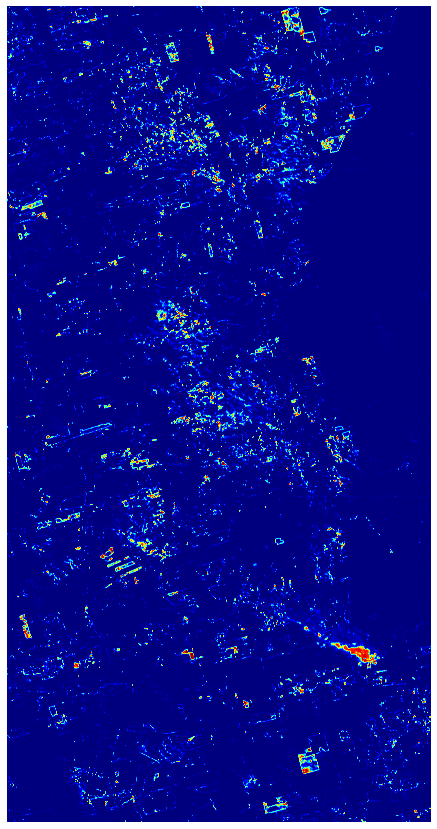

In [556]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 9199.5, 17729.5, -0.5)

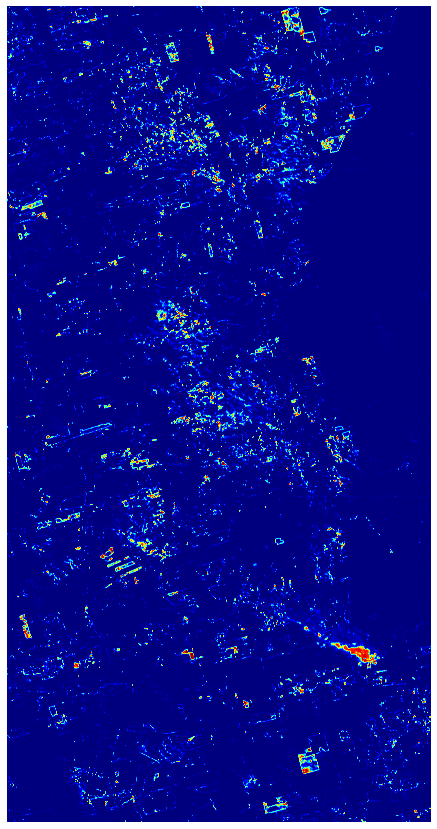

In [557]:

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 9199.5, 17729.5, -0.5)

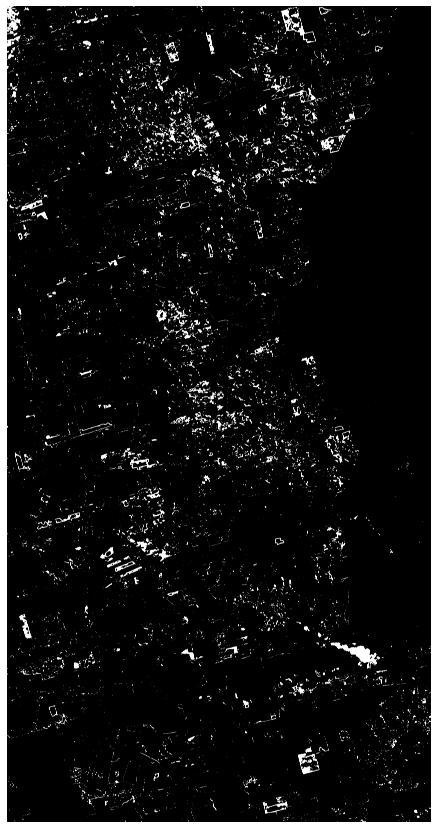

In [558]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_mask, cmap=plt.cm.gray)
plt.axis('off')


In [559]:
config = {
	"training": False,
	"save_probabilities": False,
	"loadInference": False,
	"addPastDeforestationInput": True,
	"inference_times": 10
}

import src.trainer.Trainer as t
importlib.reload(t)
trainer = t.Trainer(config, dataset, patchesHandler)


In [560]:
trainer.uncertainty = uncertainty
trainer.label_mask_current_deforestation_test = label_mask_current_deforestation_test
trainer.predicted_test = predicted_test


In [561]:
trainer.getOptimalUncertaintyThreshold(bound = 0.0015)

ic| bounds: (0.0015, 0.3663794801235199)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.1408715596097929
threshold 0.1408715596097929
(52457814,) (52457814,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1679206,)
    predicted_test_classified_incorrect.shape: (1679206,)
ic

cm_correct [[52063148     5415]
 [   42368   346883]]
cm_incorrect [[1317045   24866]
 [ 172677  164618]]


| TP_H + FN_H + FP_H + TN_H: 1679206
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 1679206
    len(label_mask_current_deforestation_test): 54137020


[0.98462949 0.89115506 0.47744121 0.0310177  0.86876992 0.48805348]
0.22700792051372695
threshold 0.22700792051372695
(53141672,) (53141672,)


ic| label_current_deforestation_test_classified_incorrect.shape: (995348,)
    predicted_test_classified_incorrect.shape: (995348,)
ic| TP_H + FN_H + FP_H + TN_H: 995348
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 995348
    len(label_mask_current_deforestation_test): 54137020


cm_correct [[52657737    10196]
 [   64937   408802]]
cm_incorrect [[722456  20085]
 [150108 102699]]
[0.97566575 0.86292663 0.56266499 0.01838572 0.83642005 0.4062348 ]
0.08763636090393405
threshold 0.08763636090393405
(51708414,) (51708414,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2428606,)
    predicted_test_classified_incorrect.shape: (2428606,)


cm_correct [[51379426     3204]
 [   28985   296799]]


ic| TP_H + FN_H + FP_H + TN_H: 2428606
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 2428606
    len(label_mask_current_deforestation_test): 54137020


cm_incorrect [[2000767   27077]
 [ 186060  214702]]
[0.98932011 0.91103001 0.40850683 0.04486036 0.8880093  0.53573443]
0.1615592917950925
threshold 0.1615592917950925
(52660257,) (52660257,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1476763,)
    predicted_test_classified_incorrect.shape: (1476763,)
ic| TP_H + FN_H + FP_H + TN_H: 1476763
    len(label_mask_current_deforestation_test

cm_correct [[52243675     6410]
 [   47504   362668]]
cm_incorrect [[1136518   23871]
 [ 167541  148833]]


): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 1476763
    len(label_mask_current_deforestation_test): 54137020


[0.9826324  0.88418517 0.49916729 0.02727825 0.86178085 0.47043373]
0.12053752310200923
threshold 0.12053752310200923
(52218776,) (52218776,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1918244,)
    predicted_test_classified_incorrect.shape: (1918244,)


cm_correct [[51847217     4474]
 [   37256   329829]]


ic| TP_H + FN_H + FP_H + TN_H: 1918244
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 1918244
    len(label_mask_current_deforestation_test): 54137020


cm_incorrect [[1532976   25807]
 [ 177789  181672]]
[0.98661693 0.89850852 0.4539685  0.03543313 0.87561633 0.50540114]
0.14557468945833152
threshold 0.14557468945833152
(52506489,) (52506489,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1630531,)
    predicted_test_classified_incorrect.shape: (1630531,)
ic

cm_correct [[52106783     5638]
 [   43521   350547]]
cm_incorrect [[1273410   24643]
 [ 171524  160954]]


| TP_H + FN_H + FP_H + TN_H: 1630531
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 1630531
    len(label_mask_current_deforestation_test): 54137020


[0.98417115 0.88955967 0.48248425 0.0301186  0.86722307 0.48410421]
0.14880875350983627
threshold 0.14880875350983627
(52539309,) (52539309,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1597711,)
    predicted_test_classified_incorrect.shape: (1597711,)
ic

cm_correct [[52136119     5787]
 [   44346   353057]]
cm_incorrect [[1244074   24494]
 [ 170699  158444]]


| TP_H + FN_H + FP_H + TN_H: 1597711
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 1597711
    len(label_mask_current_deforestation_test): 54137020


[0.98387322 0.88841051 0.48593895 0.02951236 0.86610764 0.48138347]
0.14570829362687585
threshold 0.14570829362687585
(52507843,) (52507843,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1629177,)
    predicted_test_classified_incorrect.shape: (1629177,)
ic

cm_correct [[52107994     5645]
 [   43554   350650]]
cm_incorrect [[1272199   24636]
 [ 171491  160851]]


| TP_H + FN_H + FP_H + TN_H: 1629177
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 1629177
    len(label_mask_current_deforestation_test): 54137020


[0.98415639 0.88951406 0.48262601 0.03009358 0.86718207 0.48399239]
0.1466046184390187
threshold 0.1466046184390187
(52517018,) (52517018,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1620002,)
    predicted_test_classified_incorrect.shape: (1620002,)
ic

cm_correct [[52116206     5695]
 [   43764   351353]]
cm_incorrect [[1263987   24586]
 [ 171281  160148]]


| TP_H + FN_H + FP_H + TN_H: 1620002
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 1620002
    len(label_mask_current_deforestation_test): 54137020


[0.98404976 0.88923787 0.48359361 0.02992411 0.86691134 0.48320455]
0.14744652312027537
threshold 0.14744652312027537
(52525510,) (52525510,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1611510,)
    predicted_test_classified_incorrect.shape: (1611510,)
ic

cm_correct [[52123813     5733]
 [   44005   351959]]
cm_incorrect [[1256380   24548]
 [ 171040  159542]]


| TP_H + FN_H + FP_H + TN_H: 1611510
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 1611510
    len(label_mask_current_deforestation_test): 54137020


[0.98397224 0.88886616 0.48442769 0.02976725 0.86665218 0.48260946]
0.14621715470618235
threshold 0.14621715470618235
(52513056,) (52513056,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1623964,)
    predicted_test_classified_incorrect.shape: (1623964,)
ic

cm_correct [[52112665     5672]
 [   43676   351043]]
cm_incorrect [[1267528   24609]
 [ 171369  160458]]


| TP_H + FN_H + FP_H + TN_H: 1623964
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 1623964
    len(label_mask_current_deforestation_test): 54137020


[0.98409935 0.88934913 0.48316693 0.02999729 0.86702654 0.4835592 ]
0.14618052894343797
threshold 0.14618052894343797
(52512682,) (52512682,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624338,)
    predicted_test_classified_incorrect.shape: (1624338,)
ic

cm_correct [[52112328     5670]
 [   43666   351018]]
cm_incorrect [[1267865   24611]
 [ 171379  160483]]


| TP_H + FN_H + FP_H + TN_H: 1624338
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 1624338
    len(label_mask_current_deforestation_test): 54137020


[0.98410375 0.88936466 0.48313252 0.0300042  0.86703513 0.48358354]
0.14625049020826655
threshold 0.14625049020826655
(52513422,) (52513422,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1623598,)
    predicted_test_classified_incorrect.shape: (1623598,)
ic

cm_correct [[52112981     5673]
 [   43687   351081]]
cm_incorrect [[1267212   24608]
 [ 171358  160420]]


| TP_H + FN_H + FP_H + TN_H: 1623598
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 1623598
    len(label_mask_current_deforestation_test): 54137020
ic| self.threshold_optimal: 0.14621715470618235


[0.98409829 0.889335   0.48321923 0.02999053 0.86700391 0.48351609]


In [562]:
trainer.threshold_optimal

0.14621715470618235

In [563]:
trainer.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.14621715470618235
(52513056,) (52513056,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1623964,)
    predicted_test_classified_incorrect.shape: (1623964,)
ic

cm_correct [[52112665     5672]
 [   43676   351043]]
cm_incorrect [[1267528   24609]
 [ 171369  160458]]


| TP_H + FN_H + FP_H + TN_H: 1623964
    len(label_mask_current_deforestation_test): 54137020
ic| TP_H + FN_H + FP_H + TN_H: 1623964
    len(label_mask_current_deforestation_test): 54137020


[0.98409935 0.88934913 0.48316693 0.02999729 0.86702654 0.4835592 ]
threshold 0.14621715470618235
(54137020,) (54137020,)


ic| self.m_optimal: {'AA': array([0.02999729]),
                     'f1_H': array([0.62085457]),
                     'f1_L': array([0.93432823]),
                     'precision_H': array([0.86702654]),
                     'precision_L': array([0.98409935]),
                     'recall_H': array([0.4835592]),
                     'recall_L': array([0.88934913]),
                     'recall_Ltotal': array([0.48316693])}
ic| self.m_audited_optimal: {'f1': array([0.96512726]),
                             'precision': array([0.9917623]),
                             'recall': array([0.93988543])}


cm_audited [[53404802     5672]
 [   43676   682870]]
[0.9917623  0.93988543]
